# Introduction

In this assignment you will be given a series of tasks about using the library `power-grid-model`. The tasks include:

1. [Load input](#Assignment-1:-Load-Input-Data)
2. [Validate Input Data](#Assignment-2:-Validate-Input-Data)
3. [Construct Model](#Assignment-3:-Construct-Model)
4. [Calculate One Time Power Flow](#Assignment-4:-Calculate-One-Time-Power-Flow)
5. [Time Series Batch Calculation](#Assignment-5:-Time-Series-Batch-Calculation)
6. [N 1 Scenario-Batch-Calculation](#Assignment-6:-N-1-Scenario-Batch-Calculation)

The input data are CSV files in the `data/` folder:
* `node.csv`
* `line.csv`
* `source.csv`
* `sym_load.csv`


# Preparation

First import everything we need for this workshop:

In [1]:
import time
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from power_grid_model import (
    PowerGridModel,
    CalculationType,
    CalculationMethod,
    ComponentType,
    DatasetType,
    initialize_array
)

from power_grid_model.validation import (
    assert_valid_input_data,
    assert_valid_batch_data
)

In [2]:
np.random.seed(0) # For reproducibility

Let's define a timer class to easily benchmark the calculations:

In [3]:
class Timer:
    def __init__(self, name: str):
        self.name = name
        self.start = None

    def __enter__(self):
        self.start = time.perf_counter()

    def __exit__(self, *args):
        print(f'Execution time for {self.name} is {(time.perf_counter() - self.start):0.6f} s')

The following example measures the time for a simple add operation of two numpy arrays.

In [4]:
a = np.random.rand(1000000)
b = np.random.rand(1000000)
with Timer("Add Operation"):
    c = a + b

Execution time for Add Operation is 0.003175 s


# Assignment 1: Load Input Data

The following function loads the CSV data files from folder `../data/` and convert them into one dictionary of numpy structured arrays. The returned dictionary is a compatible input for the constructor of `PowerGridModel`. Please complete the function to construct the input data which is compatible with `PowerGridModel`.

In [5]:
def load_input_data() -> Dict[str, np.ndarray]:
    input_data = {}
    for component in [ComponentType.node, ComponentType.line, ComponentType.source, ComponentType.sym_load]:
        
        # Use pandas to read CSV data
        df = pd.read_csv(f'../data/{component.value}.csv')

        # Initialize array
        input_data[component] = initialize_array(DatasetType.input, component, len(df))

        # Fill the attributes
        for attr, values in df.items():
            input_data[component][attr] = values

        # Print some debug info
        print(f"{component:9s}: {len(input_data[component]):4d}")

    return input_data

# Load input data
with Timer("Loading Input Data"):
    input_data = load_input_data()


ComponentType.node: 2001
ComponentType.line: 2000
ComponentType.source:    1
ComponentType.sym_load: 2000
Execution time for Loading Input Data is 0.008821 s


# Assignment 2: Validate Input Data

It is recommended to validate your data before constructing the `PowerGridModel`. If you are confident about your input data, you can skip this step for performance reasons. The easiest way to validate your input data is using `assert_valid_input_data`, which will raise an exception if there are any errors in your data. Please have a look at the [Validation Examples](https://github.com/PowerGridModel/power-grid-model/blob/main/examples/Validation%20Examples.ipynb) for more detailed information on the validation functions.

In [6]:
# Validate input data
with Timer("Validating Input Data"):
    assert_valid_input_data(input_data=input_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Input Data is 0.006538 s


# Assignment 3: Construct Model

Create an instance of `PowerGridModel` using the input data. Benchmark the construction time.

In [7]:
# Construct model
with Timer("Model Construction"):
    model = PowerGridModel(input_data=input_data)

# Print the number of objects
print(model.all_component_count)

Execution time for Model Construction is 0.001295 s
{<ComponentType.node: 'node'>: 2001, <ComponentType.line: 'line'>: 2000, <ComponentType.source: 'source'>: 1, <ComponentType.sym_load: 'sym_load'>: 2000}


# Assignment 4: Calculate One-Time Power Flow

* Calculate one-time power flow, print the highest and lowest loading of the lines.
* Try with Newton-Raphson and linear method, compare the results and speed.

In [8]:
# Newton-Raphson Power Flow
with Timer("Newton-Raphson Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.newton_raphson)
    
# Print min and max line loading
print("Min line loading:", min(result[ComponentType.line]["loading"]))
print("Max line loading:", max(result[ComponentType.line]["loading"]))

Execution time for Newton-Raphson Power Flow is 0.002740 s
Min line loading: 0.1418844978380699
Max line loading: 1.6292378285645368


In [9]:
# Linear Power Flow
with Timer("Linear Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.linear)
    
# Print min and max line loading
print("Min line loading:", min(result[ComponentType.line]["loading"]))
print("Max line loading:", max(result[ComponentType.line]["loading"]))

Execution time for Linear Power Flow is 0.000906 s
Min line loading: 0.1395686087394204
Max line loading: 1.6156849991055762


# Assignment 5: Time Series Batch Calculation

## Load Profile

Below we randomly generate a dataframe of load profile. 

* The column names are the IDs of `sym_load`
* Each row is one scenario
* Each entry specifies the active power of the load
* The reactive power is zero


In [10]:
# Generate random load profile oh hourly data
n_scenarios = 1000
n_loads = len(input_data[ComponentType.sym_load]) 
load_id = input_data[ComponentType.sym_load]["id"]
load_p = input_data[ComponentType.sym_load]["p_specified"]
profile = np.tile(load_p, (n_scenarios, 1)) + 5e5 * np.random.randn(n_scenarios, n_loads)
dti = dti = pd.date_range("2022-01-01", periods=n_scenarios, freq="h")
df_load_profile = pd.DataFrame(profile, columns=load_id, index=dti)
display(df_load_profile)

,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,...,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001
2022-01-01 00:00:00,6.542975e+05,1.526274e+06,9.835916e+05,7.105664e+05,1.330337e+06,7.035255e+05,9.643857e+05,8.958759e+05,9.889155e+05,1.268703e+06,...,8.455310e+05,1.162544e+06,2.558481e+05,1.382856e+06,8.314504e+05,5.324480e+05,6.195114e+05,1.479162e+06,9.123626e+05,1.043085e+06
2022-01-01 01:00:00,1.599202e+06,1.624803e+06,8.515054e+05,1.272474e+06,2.538246e+05,1.166365e+06,5.340211e+05,9.061211e+05,1.638968e+06,1.048253e+06,...,1.008758e+06,8.637050e+05,1.370746e+06,7.853128e+05,1.284208e+06,7.125573e+05,2.025939e+06,1.413798e+06,3.033545e+05,1.402499e+06
2022-01-01 02:00:00,6.262723e+05,-3.936538e+04,7.729855e+05,1.240346e+06,1.372449e+06,1.834328e+05,1.029736e+06,2.278456e+05,1.095536e+06,6.710179e+05,...,1.085567e+06,1.132255e+06,2.623313e+05,1.500894e+06,1.260842e+06,5.876514e+05,6.996802e+05,1.566650e+06,7.006146e+05,9.703639e+05
2022-01-01 03:00:00,1.702868e+05,1.143364e+06,1.963476e+06,9.099949e+05,1.381601e+06,5.030083e+05,1.830331e+06,8.439323e+05,1.762296e+06,1.740743e+06,...,1.603770e+06,9.406809e+05,2.998462e+05,6.051862e+05,5.224477e+05,8.286061e+05,7.509667e+05,3.962129e+05,2.096399e+05,9.802467e+05
2022-01-01 04:00:00,1.043548e+06,2.188358e+05,1.127129e+06,5.473136e+05,1.790570e+06,6.960018e+05,7.261024e+05,1.021764e+06,2.221873e+06,1.006030e+06,...,1.389082e+06,6.831849e+05,1.802030e+06,-1.220805e+05,2.803788e+05,9.146118e+05,4.157669e+05,8.818861e+05,1.153413e+06,1.987920e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11 11:00:00,1.297461e+06,1.047677e+06,4.578420e+05,9.740551e+05,8.286470e+05,-1.629241e+04,9.824188e+05,5.312199e+05,7.728044e+05,7.764914e+05,...,7.648894e+05,1.354775e+06,7.579497e+05,9.702597e+05,3.766778e+05,4.840460e+05,1.303803e+06,6.944711e+05,1.212502e+06,1.069479e+06
2022-02-11 12:00:00,3.749362e+04,5.913280e+05,8.999378e+05,1.775253e+06,3.648972e+05,6.752172e+05,1.014593e+06,7.456549e+05,1.129800e+06,6.698132e+05,...,1.374550e+06,9.377212e+05,1.051601e+06,9.014852e+05,2.029342e+06,1.648292e+06,1.640126e+06,1.634752e+06,1.224935e+06,1.654338e+06
2022-02-11 13:00:00,8.100687e+05,8.121140e+04,1.193171e+06,4.289758e+05,1.811121e+06,1.276082e+06,1.105754e+06,1.081095e+06,9.712173e+05,1.525249e+06,...,5.449206e+05,7.953469e+05,3.476170e+03,2.816748e+05,3.704842e+05,7.392224e+05,1.148101e+06,7.661535e+05,1.192877e+06,1.314111e+06
2022-02-11 14:00:00,1.297348e+06,8.867596e+05,4.085110e+05,8.674707e+05,2.748922e+05,1.244640e+06,7.688895e+05,2.527199e+05,5.978268e+05,1.480678e+06,...,5.123765e+05,1.049253e+06,1.005289e+06,1.228138e+06,1.219614e+06,6.556987e+05,1.051950e+06,1.713633e+06,6.839066e+05,1.003103e+06


## Run Time Series Calculation

We want to run a time-series load flow batch calculation using the dataframe.

* Convert the load profile into the compatible batch update dataset.
* Run the batch calculation.
* Compare the calculation methods `newton_raphson` and `linear`.

In [11]:
# Initialize an empty load profile
load_profile = initialize_array(DatasetType.update, ComponentType.sym_load, df_load_profile.shape)

# Set the attributes for the batch calculation (assume q_specified = 0.0)
load_profile["id"] = df_load_profile.columns.to_numpy()
load_profile["p_specified"] = df_load_profile.to_numpy()
load_profile["q_specified"] = 0.0

# Construct the update data
update_data = {ComponentType.sym_load: load_profile}

In [12]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 1.104897 s


In [13]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    output_data = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 0.868429 s


In [14]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    output_data_linear = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 0.391254 s


## Plotting batch results

Lets say we wish to plot the loading of the `line with id 2007` vs time. We can use matplotlib to do so. (Note: The grid and results are randomly generated so dont be alarmed to see loading >100% or other unrealistic result)  

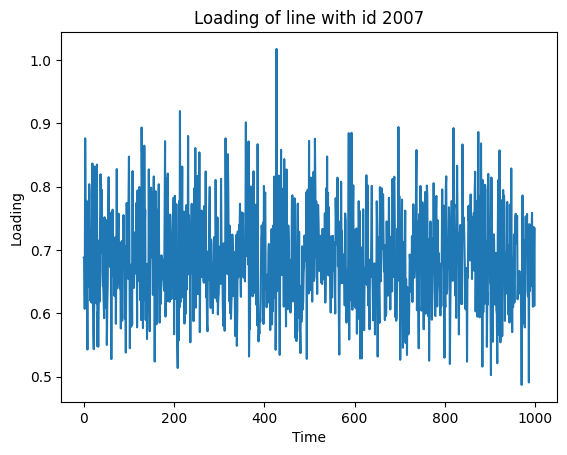

In [15]:
# Plot the loading of line with id 2007 vs time.
line_2007_idx = np.where(output_data[ComponentType.line]["id"] == 2007)
result_loading = output_data[ComponentType.line]["loading"][line_2007_idx]
plt.plot(result_loading)
plt.title('Loading of line with id 2007')
plt.xlabel('Time')
plt.ylabel('Loading')
plt.show()

## Indexing the results

Find the time stamps where loading in `line with id 2007` is greater than `90%`

In [16]:
# Times when loading of line with id 2007 when its greater than 90%
ind = np.where(result_loading > 0.9)
df_load_profile.index[ind]

DatetimeIndex(['2022-01-09 21:00:00', '2022-01-15 23:00:00',
               '2022-01-18 19:00:00'],
              dtype='datetime64[ns]', freq=None)

# Assignment 6: N-1 Scenario Batch Calculation

We want to run a N-1 Scenario analysis. For each batch calculation, one `line` is disconnected at from- and to-side.

In [17]:
n_lines = len(input_data[ComponentType.line])

# Initialize an empty line profile
line_profile = initialize_array(DatasetType.update, ComponentType.line, (n_lines, n_lines))

# Set the attributes for the batch calculation
line_profile["id"] =  input_data[ComponentType.line]["id"]
line_profile["from_status"] = 1 - np.eye(n_lines, dtype=np.uint8)
line_profile["to_status"] = 1 - np.eye(n_lines, dtype=np.uint8)

# Construct the update data
update_data = {ComponentType.line: line_profile}

In [18]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 2.233256 s


In [19]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 2.829016 s


In [20]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 1.757972 s


## Parallel processing
The `calculate_power_flow` method has an optional `threading` argument to define the number of threads ran in parallel. Experiment with different threading values and compare the results...

In [21]:
# By default, sequential threading is used
with Timer("Sequential"):
    model.calculate_power_flow(update_data=update_data)

# Single thread, this is essentially the same as running a single thread
with Timer("Single thread"):
    model.calculate_power_flow(update_data=update_data, threading=1)

# Two threads should be faster    
with Timer("Two threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=2)

# Four threads should be even faster    
with Timer("Four threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=4)

# Use number of threads based the machine hardware    
with Timer("Use number of threads based the machine hardware"):
    model.calculate_power_flow(update_data=update_data, threading=0)

Execution time for Sequential is 2.820270 s


Execution time for Single thread is 2.799965 s


Execution time for Two threads in parallel is 1.377237 s


Execution time for Four threads in parallel is 0.731595 s


Execution time for Use number of threads based the machine hardware is 0.545823 s
